# Machine Learning Engineer Nanodegree
## Capstone Project : Using Social Media to Predict Stock Movement
Venu Vasudevan  
April 2nd, 2017

## Definition


### Project Overview

Social media platforms such as StockTwits can provide a wealth of user-generated data about retail investor expectations (and hopes!) as relates to a particular stock. Many studies on the [wisdom of crowds](https://goo.gl/NUu7ek) have shown that there is predictive intelligence in the collective insight of crowds of non-experts (in this case retail investor). For instance, there has been anecdotal evidence (despite the secrecy in hedge fund strategy) of hedge funds using [Twitter behavior](http://fortune.com/2015/12/07/dataminr-hedge-funds-twitter-data/) to make investment decisions. 

I believe, as these financial institutions do, that there is a correlation between investor sentiment and stock movement. Since these strategies are not available in open source, this project aims to test whether investor sentiment in a rolling window can be used to drive a trading strategy of buying and holding in a 3-day window.

### Problem Statement

The problem to be solved in this project is to learn the **correlation between changes in sentiment (bullish/bearish polarity of investor comments about a particular stock in Social Media) and individual stock returns over the next 3 days**. I would like to explore a variety of machine learning techniques and compare their effectiveness in predicting the 3-day return on those particular stocks. 

I do not intend to generate any technical measures (e.g. based on whether stock is at 'support' or 'resistance') except to consider it as an option for dealing with the situation of not being able to meet the evaluation metric.

If successful, the project will provide concrete results on:
- whether it is possible to predict a stock's 3-day return based on changes in investor sentiment on that stock
- whether any particular technique (currently under consideration - regression, boosting, SVM and possibly for a stretch goal, RNNs) does better than others
- whether there are stock-specific variations on the efficacy of this predictor


### Evaluation Metrics

Based on comments from reviewers, I am proposing two evaluation metrics - one for iterative improvement and the other for overall result satisfaction. Since this is a binary classification task (trade or no trade based on whether 3-day prognosis is up or down), I **intend to use precision and the classic F1-score** to measure the quality of predictions based entirely on features and label. Precision is useful for the capital preservation benchmark below, our goal is to avoid _errors of commission_ in investing for capital preservation. The F1-score brings recall into the equation and allows for more refined and profitable trading strategies in the future. For an additional overall metric, see the discussion below.

My overall evaluation metric mirrors the intuitive 'bars' that investors set in choosing an advisor for their portfolio. I have depicted 3 benchmarks below to demonstrate an awareness of the kinds of bars I can set. For this project I choose the **capital preservation benchmark** over a period of 3 months in testing the trained model.
- **coin-flip benchmark.** have a strategy that is better than random (a coin-flip strategy). this benchmark is clear and quantifiable, but not repeatable, since it is random by design.
- **capital preservation benchmark.** this benchmark states that the net portfolio should do as well or better than cash (earning 0% interest). this may seem easy, but given that the learning algorithm has to make at least one trade in the time period, it might be harder than anticipated. that said, this is both intuitively of value to clients, and is all of easy, quantifiable and repeatable.
- **beat the index benchmark.** this benchmark would require the collection of trades to outperform a selected index (say S&P500). this is going to be challenging because the one (or few) stocks comprising the trading set may have inherently negative deviations from the index due to stock or sector specific dynamics. this is an ambitious, aspirational benchmark i will strive for, but it might require me to include 'shorting' (betting on a stock going down) as part of the action set.

## Analysis

### Data Exploration
The inputs used here are Stocktwits data as _a source of investor sentiment_  and the Yahoo Finance _closing prices_ of the stocks to which these comments relate.
- **Yahoo Finance** is used as sources of stock closing price information. This dataset will be used to determine if the returns for a fixed trading transaction over a rolling 3-day window. The quick summary of Yahoo finance data below shows the following:
    - the data covers about two years worth of data for Boeing (Ticker: BA). There are equivalent data sets for 9 other stocks as will be apparent in future sections
    - the data set is fairly clean (no NA's) and gives some indication of the volatility of the stock in a 2-yr period
   
- **StockTwits** is a 'wider' dataset with about 23 columns providing not only investor comments but information about its source and popularity
    - this summary shows that we have about 15K comments for Boeing (ticker BA) over the 2 year period. Later data will show that we have about 150K comment corpus in aggregate
    - the data set is textual and 'untidy' compared to Yahoo Finance, with many columns having NA's that need re-interpreting.
    - a quick examination of the head of the dataframe shows that:
        - much of the content is short text and specialized vocabulary (e.g. sell,put,call) 
        - spelling mistakes and sentences that are not grammatically complete (and might need stemming and lemmatization)
        - a number of the fields here may be redundant for the learning task at hand

In [2]:
import pandas as pd
import numpy as np
import pandas_datareader as web

df = pd.read_json('data/BA.json')
start = df['created_at'].min()
end = df['created_at'].max()
closings = web.DataReader('BA','google', start, end)
print("**Yahoo Finance : Stock Price Data Description**")
print(list(closings))
print(closings.describe())


print("\n\n**Stocktwits User Comments Data Description**")
print(list(df))
print(df.describe())
print(df['sentiment'].head(2))

**Yahoo Finance : Stock Price Data Description**
['Open', 'High', 'Low', 'Close', 'Volume']
             Open        High         Low       Close        Volume
count  504.000000  504.000000  504.000000  504.000000  5.040000e+02
mean   141.117421  142.297540  139.951290  141.185020  4.004558e+06
std     14.242020   14.180797   14.365903   14.242404  2.358894e+06
min    105.120000  109.840000  102.100000  108.440000  9.623870e+05
25%    131.552500  132.472500  130.495000  131.270000  2.840669e+06
50%    140.360000  141.230000  139.160000  140.250000  3.479328e+06
75%    147.510000  148.647500  146.472500  147.820000  4.596597e+06
max    184.000000  185.710000  182.970000  183.910000  3.369557e+07


**Stocktwits User Comments Data Description**
['body', 'classes', 'conversation', 'created_at', 'direct', 'id', 'in_reply_to_message_id', 'investor_relations', 'link_embed', 'links', 'mention_ids', 'message_source', 'message_type', 'reshare_message', 'sentiment', 'show_embeds', 'show_expanded'

### Exploratory Visualization

_A visualization has been provided that summarizes or extracts a relevant
characteristic or feature about the dataset or input data with thorough
discussion. Visual cues are clearly defined._

foo
bar
['body', 'classes', 'conversation', 'created_at', 'direct', 'id', 'in_reply_to_message_id', 'investor_relations', 'link_embed', 'links', 'mention_ids', 'message_source', 'message_type', 'reshare_message', 'sentiment', 'show_embeds', 'show_expanded', 'source', 'structurable', 'total_likes', 'total_reshares', 'user', 'view_chart', 'class', 'name']
(723,)
created_at
2015-03-29     7
2015-03-30    30
2015-03-31    15
2015-04-01    12
2015-04-02    11
2015-04-03    13
2015-04-04     4
2015-04-05     4
2015-04-06    17
2015-04-07    20
dtype: int64
              Open    High     Low   Close   Volume
Date                                               
2015-03-30  150.08  153.17  149.98  152.70  3738731
2015-03-31  152.23  152.25  149.94  150.08  2975622
2015-04-01  149.97  150.02  146.82  148.64  4167631
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
(504, 3)
             Close   Volume  msg_volume
Date                                   
2015-03-30  152.70  

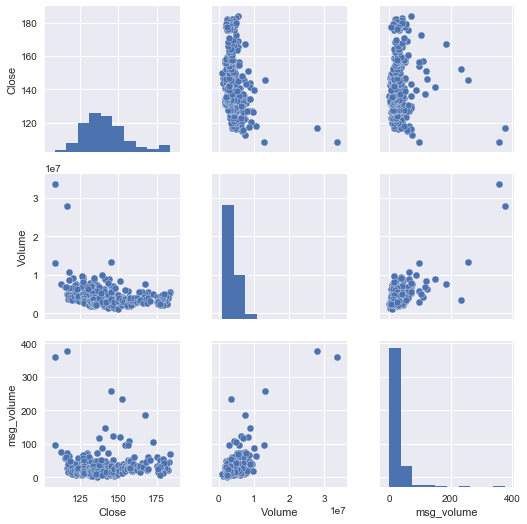

In [3]:
# import pandas_datareader as web

def one_day_return (stock_quotes):
    sLength = len(stock_quotes)
    stock_quotes['one_day_return'] = pd.Series(np.random.randn(sLength), index=stock_quotes.index)
    
    for i in range(0,len(stock_quotes)):
        row_to_change = stock_quotes.iloc[i]
        
        if i < (len(stock_quotes)-2):
            one_day_later_row = stock_quotes.iloc[i+1]
            #three_day_return = stock_quotes.iloc[i]['Close'] - stock_quotes.iloc[i-3]['Close']
            one_day_return = one_day_later_row['Close'] - row_to_change['Close'] 
        else:
            one_day_return = 0
        #stock_quotes.iloc[i]['three_day_return'] = three_day_return
        row_to_change['one_day_return'] = three_day_return

# download BA stocktwits
print("foo")
ba_flattened= df['sentiment'].apply(pd.Series) #flatten the sentiment JSON to 2 values
print("bar")
df=df.join(ba_flattened)
print(list(df))
df['created_at'] = df['created_at'].dt.date
#print("df explicit shape -- ",df.shape)
df = df.groupby('created_at').size()
print(df.shape)
print(df.head(10))


# download BA stock price
cq_frame=web.DataReader("BA",'google', start, end)
#cq_frame['one_day_return'] = one_day_return(cq_frame)
print(cq_frame.head(3))
print (type(cq_frame),type(df))
#    closings = get_closing_quotes(ticker,start,end)
#cq_merged = cq_frame.merge(df.to_frame(), left_index=True, right_index=True, how='left')
df.name='msg_volume'
cq_merged = cq_frame.join(df.to_frame())
cq_merged.drop('Open',axis=1,inplace=True)
cq_merged.drop('High',axis=1,inplace=True)
cq_merged.drop('Low',axis=1,inplace=True)
print(cq_merged.shape)
print(cq_merged.head(5))

# draw two subplots - stock price over time. bullish comments over time
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure()
sns.pairplot(data=cq_merged[["Close","Volume","msg_volume"]],
             hue= None, dropna=True)
plt.savefig("exploratory_plot.png")
plt.show()

### Algorithms & Techniques
_Algorithms and techniques used in the project are thoroughly discussed and
properly justiedbased on the characteristics of the problem._


### Benchmark
I plan to use the precision and F1-scores received from Naive Bayes as the benchmark to improve upon for the other algorithms I'll compare as part of the trading strategy

## Methodology


### Data Preprocessing
From past experience I expect the stock closing ticker data to be quite clean since it is not user generated. But since my solution depends on social network information (in particular explicit sentiment), I performed a coarse data exploration below to a) estimate the size of my user comment corpus, and b) the number of comments that are explictly annotated with investor sentiment (bullish/bearish).

#### Do we have enough comments?

The code below shows that we have about 171K comments over 2 years across the ten stocks that is fairly evenly distributed

In [4]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

stwit_summary = pd.DataFrame(columns=('ticker', 'sentiment_ratio', 'num_comments'))
path = 'data/'

total_comments = 0
for infile in glob.glob( os.path.join(path, '*.json') ):
    base=os.path.basename(infile)
    ticker = os.path.splitext
    #print("****\ncurrent sto(base)[0]ck ticker is: " + ticker)
    
    df = pd.read_json(infile)
    num_comments = df.shape[0]
    #print("number of comments for ",ticker," - ",df.shape[0])
    #print(list(df))
    total_comments += num_comments
    
    real_sentiment = pd.notnull(df['sentiment']).astype(int)
    sentiment_ratio = real_sentiment.mean()*100
    #print ("% comments with explicit sentiment",real_sentiment.mean()*100)
    arow = [ticker,sentiment_ratio,num_comments]
    stwit_summary.loc[len(stwit_summary)] = arow

print("##total # stocktwit comments --",total_comments)
#stwit_summary.plot(x='ticker', y='sentiment_ratio', style='o')
plt.show()


#sns.set(style="whitegrid", color_codes=True)
#sns.stripplot('ticker', 'sentiment_ratio', data=stwit_summary)

#print("****stocktwits column structure and sample comments****")
print(list(df))
df.head(5)


##total # stocktwit comments -- 171860
['body', 'classes', 'conversation', 'created_at', 'direct', 'id', 'in_reply_to_message_id', 'investor_relations', 'link_embed', 'links', 'mention_ids', 'message_source', 'message_type', 'reshare_message', 'sentiment', 'show_embeds', 'show_expanded', 'source', 'structurable', 'total_likes', 'total_reshares', 'user', 'view_chart']


,body,classes,conversation,created_at,direct,id,in_reply_to_message_id,investor_relations,link_embed,links,...,reshare_message,sentiment,show_embeds,show_expanded,source,structurable,total_likes,total_reshares,user,view_chart
0,Share an idea on $VZ question does VZ go ex di...,default,"{'path': '/message/78619986#78619986', 'parent...",2017-03-28 20:04:48,False,78619986,NaN,False,NaN,[],...,NaN,"{'class': 'bullish', 'name': 'Bullish'}",False,False,None,NaN,0,0,"{'username': 'longtermopportunity', 'id': 8060...",NaN
1,$VZ https://sg.finance.yahoo.com/news/white-ho...,default,NaN,2017-03-28 19:39:34,False,78615256,NaN,False,{'provider_url': 'https://sg.finance.yahoo.com...,[{'provider_url': 'https://sg.finance.yahoo.co...,...,NaN,None,False,False,"{'url': 'http://www.stocktwits.com/mobile', 'i...",NaN,1,0,"{'username': 'serg00', 'id': 964333, 'name': '...",NaN
2,Drexel Hamilton Reviews $VZ #Verizon's Two Qua...,default,NaN,2017-03-28 19:03:37,False,78609300,NaN,False,"{'provider_url': 'http://smartstocknews.com', ...","[{'provider_url': 'http://smartstocknews.com',...",...,NaN,None,False,False,None,NaN,0,0,"{'username': 'MinaKevin', 'id': 655556, 'name'...",NaN
3,$VZ VZ put sale over earnings. *Note I am not ...,default suggested,NaN,2017-03-28 17:06:14,False,78590768,NaN,False,NaN,[],...,NaN,"{'class': 'bullish', 'name': 'Bullish'}",False,False,"{'url': 'https://www.tradingview.com', 'id': 1...",NaN,0,0,"{'username': 'newsomenuggets', 'id': 204151, '...","{'path': '/message/78590768#78590768', 'image'..."
4,"$T $VZ AT&T and Verizon, we're definitely shor...",default,"{'path': '/message/78589300#78589300', 'parent...",2017-03-28 16:56:49,False,78589300,NaN,False,NaN,[],...,NaN,None,False,False,None,NaN,0,0,"{'username': 'TradeSquawk', 'id': 995834, 'nam...",NaN


#### Text analytics on bullish and bearish comments

The code below uses some simple linguistics techniques (e.g. stop word lists) and TF-IDF to come up with a short list of words that are typical in bullish and bearish StockTwits comments. 

Given that only about 20% of the comments are explicitly labeles bullish/bearish, a short list of these words will be used as _features_ to label unlabeled comments as bullish or bearish, in case the volume of explicitly labeled comments is insufficient for the learning algorithms

**manual curation of the TF-IDF screen below**:
- bullish - buy, long, bullish, big, higher, bought, strong, purchase, calls, resistance, upside, positive
- bearish - bearish, sell, short, puts, overbought, sold, break, selling, shorts, costly, lower, collapse, , downtrend, bear

In [5]:
import textblob

# read in s&p 500 tickers to include as stop word in TF-IDF
tickers = pd.read_csv('data/sp.csv',header=None)
print("tickers size - ",tickers.shape)
ticker_str = tickers[0].astype(str)
ticker_str = [t.lower() for t in ticker_str]

tickers size -  (505, 1)


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 
import collections


cnt = collections.Counter()
bear_cnt = collections.Counter()

#union_array = set()
for infile in glob.glob( os.path.join(path, '*.json') ):
    df = pd.read_json(infile)
    #get ride of None values - http://stackoverflow.com/questions/32207264/pandas-query-none-values
    df = df.query('sentiment == sentiment')
    #http://stackoverflow.com/questions/18665284/how-do-i-access-embedded-json-objects-in-a-pandas-dataframe
    flattened= df['sentiment'].apply(pd.Series)
    df=df.join(flattened)

    df_bull = df[df['class']=='bullish']
    df_bear = df[df['class']=='bearish']

    df_bull_comment = df_bull['body']
    df_bear_comment = df_bear['body']
    
    bull_polarities=[]
    bull_count = 0
    bull_sentiment = 0
    for i, val in df_bull_comment.iteritems():
        testimonial = textblob.TextBlob(val)
        bull_polarities.append(testimonial.sentiment.polarity)
        bull_sentiment += testimonial.sentiment.polarity
        bull_count += 1
    #print ("for ",infile," average bull sentiment - ", float(bull_sentiment/bull_count))
    #print ("for ",infile,"mean bull sentiment - ",np.mean(bull_polarities),
    #       ", std - ",np.std(bull_polarities))
    
    bear_count = 0
    bear_sentiment = 0
    bear_polarities=[]
    for i, val in df_bear_comment.iteritems():
        testimonial = textblob.TextBlob(val)
        bear_polarities.append(testimonial.sentiment.polarity)
        bear_sentiment += testimonial.sentiment.polarity
        bear_count += 1
    #print ("for ",infile," average bear sentiment - ", float(bear_sentiment/bear_count))
    #print ("for ",infile,"mean bear sentiment - ",np.mean(bear_polarities),
    #       ", std - ",np.std(bear_polarities))
    
    # add s&p 500 tickers and company names to stop words
    custom_stop_words = text.ENGLISH_STOP_WORDS.union(ticker_str)
    company_names = ['cisco', 'google', 'alphabet', 'aapl', 'apple','verizon','tmus']
    other_crap = ['10','com','http','https','today','tomorrow','www','2016']
    custom_stop_words = custom_stop_words.union(company_names)
    custom_stop_words = custom_stop_words.union(other_crap)
    
    vectorizer = TfidfVectorizer(sublinear_tf=True,min_df=.02,stop_words=custom_stop_words)
    X = vectorizer.fit_transform(df_bull_comment)
    
    idf = vectorizer.idf_
    for word in vectorizer.get_feature_names():
        cnt[word] += 1
    #union_array = union_array.union(vectorizer.get_feature_names())

    bear_vectorizer = TfidfVectorizer(sublinear_tf=True,min_df=.02,stop_words=custom_stop_words)
    bear = bear_vectorizer.fit_transform(df_bear_comment)
    for word in bear_vectorizer.get_feature_names():
        bear_cnt[word] += 1
        
print("*** bullish commentary term frequency counter - ****")
print(cnt.most_common())

print("\n\n*** bearish commentary term frequency counter - ****")
print(bear_cnt.most_common())
#    print(dict(zip(vectorizer.get_feature_names(), idf)))
    #print(vectorizer.get_feature_names())

*** bullish commentary term frequency counter - ****
[('buy', 10), ('good', 10), ('great', 10), ('long', 10), ('stks', 10), ('stock', 10), ('stocks', 10), ('bullish', 9), ('earnings', 9), ('going', 9), ('just', 9), ('like', 9), ('market', 9), ('new', 9), ('price', 9), ('week', 9), ('day', 8), ('spy', 8), ('news', 8), ('time', 7), ('big', 7), ('dividend', 7), ('high', 6), ('nice', 5), ('buying', 5), ('calls', 5), ('growth', 5), ('stkw', 5), ('looking', 4), ('looks', 4), ('share', 4), ('tech', 4), ('higher', 4), ('twtr', 4), ('days', 4), ('50', 4), ('bbry', 3), ('stockrow', 3), ('baba', 3), ('qqq', 3), ('100', 3), ('ibb', 3), ('xbi', 3), ('year', 3), ('defense', 2), ('30', 2), ('32', 2), ('investorplace', 2), ('er', 2), ('mnkd', 2), ('cloud', 2), ('trading', 2), ('biotech', 2), ('bit', 2), ('bought', 2), ('company', 2), ('labu', 2), ('ly', 2), ('anchor', 2), ('azn', 2), ('breakout', 2), ('cancer', 2), ('drug', 2), ('future', 2), ('nvs', 2), ('nyse', 2), ('past', 2), ('pharma', 2), ('posi

#### Adding synthetic features

Message volume, 1-day change (percentage), Message volume vs. 10-day average message
volume (percentage), Message polarity, calculated as the difference
of bullish to bearish messages, divided by the total number of sentiment tagged
messages

In [7]:
from datetime import date
import pandas_datareader as web
import datetime

bull_set = ['buy', 'long', 'bullish', 'big', 'higher', 'bought', 'strong', 
            'purchase', 'calls', 'resistance', 'upside', 'positive' ]
bear_set = ['bearish', 'sell', 'short', 'puts', 'overbought', 'sold', 'break', 
            'selling', 'shorts', 'costly', 'lower', 'collapse', 'downtrend', 'bear']

def msg_count(stock_cmts):
    stock_cmts['created_at_date'] = stock_cmts['created_at'].dt.date
    cmt_count = stock_cmts.groupby('created_at_date').size()
    return cmt_count

def soft_match(sentence,word_set):
    search_words = set(word_set)
    blob = textblob.TextBlob(sentence)
    matches = [str(s) for s in blob.sentences if search_words & set(s.words)]
    return len(matches)

def get_closing_quotes(ticker,start,end):
    cq_frame=web.DataReader(ticker,'google', start, end)
    return cq_frame

def add_three_day_return (stock_quotes):
    sLength = len(stock_quotes)
    stock_quotes['three_day_return'] = pd.Series(np.random.randn(sLength), index=stock_quotes.index)
    
    for i in range(0,len(stock_quotes)):
        row_to_change = stock_quotes.iloc[i]
        
        if i < (len(stock_quotes)-4):
            three_day_later_row = stock_quotes.iloc[i+3]
            #three_day_return = stock_quotes.iloc[i]['Close'] - stock_quotes.iloc[i-3]['Close']
            three_day_return = three_day_later_row['Close'] - row_to_change['Close'] 
        else:
            three_day_return = 0
        #stock_quotes.iloc[i]['three_day_return'] = three_day_return
        row_to_change['three_day_return'] = three_day_return
        

for infile in glob.glob( os.path.join(path, '*.json') ):
    base=os.path.basename(infile)
    ticker = os.path.splitext(base)[0] 
    print("**ticker --",ticker)
#df_all = pd.read_json('data/BA.json') #df_all is comments with or without sentiment info
    df_all = pd.read_json(infile)
    #print("df_all shape",df_all.shape)
    #print("min date -- ",df_all['created_at'].min())
    #print("max date -- ",df_all['created_at'].max())

    #total_msgs = msg_count(df_all)
    #total_msgs_percent_change = total_msgs.pct_change()
    #total_msgs_rolling_mean = total_msgs.rolling(window=5).mean()

    #get rid of None values - http://stackoverflow.com/questions/32207264/pandas-query-none-values
    df = df_all.query('sentiment == sentiment') #should be called df_explicit, has sentiment value

    df_implicit = df_all[~df_all.index.isin(df.index)] #implicit sentiment set
    #print("df implicit shape -- ",df_implicit.shape)
    
    #http://stackoverflow.com/questions/18665284/how-do-i-access-embedded-json-objects-in-a-pandas-dataframe
    flattened= df['sentiment'].apply(pd.Series) #flatten the sentiment JSON to 2 values
    df=df.join(flattened)
    df['created_at'] = df['created_at'].dt.date
    #print("df explicit shape -- ",df.shape)
    df_days = df.groupby('created_at').size()
    #print("crowd sentiment traffic by days shape -- ",df_days.shape)
    print("crowd sentiment traffic by days -- ")
    print(df_days.head(10))

    df_bull = df[df['class']=='bullish']
    #print("df_bull shape -- ",df_bull.shape)
    df_bear = df[df['class']=='bearish']
    #print("df_bear shape -- ",df_bear.shape)


    # TODO : add implicit bullish/bearish to df_bull and df_bear
    implicit_count=0
    df_implicit_bull = pd.DataFrame(data=None, columns=df.columns,index=df.index)
    df_implicit_bear = pd.DataFrame(data=None, columns=df.columns,index=df.index)

    df_bull_days = df_bull.groupby('created_at').size()
    print("*** bull days shape ***",df_bull_days.shape)
    #print(df_bull_days.head(5))


    df_bear_days = df_bear.groupby('created_at').size()
    print("*** bear days shape ***",df_bear_days.shape)
    print(df_bear_days.head(2))
    #print(list(df_bear))

    df_combined = pd.concat([df_bull_days, df_bear_days],axis=1)
    df_combined.columns = ['bullish_count', 'bearish_count']
    #print("*** combined shape ***",df_combined.shape)
    df_combined.head(14)
    #print(list(df_combined))
    
    
    total_msgs = msg_count(df_all)
    total_msgs_percent_change = total_msgs.pct_change()
    total_msgs_rolling_mean = total_msgs.rolling(window=5).mean()
    
    start = df_all['created_at'].min()
    end = df_all['created_at'].max()
    closings = get_closing_quotes(ticker,start,end)
    add_three_day_return(closings)
    closings['positive_return'] = closings['three_day_return'] > 0
    closings['positive_return'] = closings['positive_return'].apply(lambda x: 1 if x==True else 0)

    named_msgs = total_msgs.to_frame('message_volume')
    merged = closings.merge(named_msgs, left_index=True, right_index=True)
    #print(named_msgs.shape,merged.shape)
    percent_change_msgs = total_msgs_percent_change.to_frame('percent_msg_traffic_change')
    merged = merged.merge(percent_change_msgs, left_index=True, right_index=True)
    #print(percent_change_msgs.shape,merged.shape)
    rolling_means = total_msgs_rolling_mean.to_frame('msg_rolling_mean')
    merged = merged.merge(rolling_means, left_index=True, right_index=True)
    #print(rolling_means.shape, merged.shape)

    bears = df_bear_days.to_frame('bearish_count')
    print(bears.head(5))
    merged = merged.merge(bears, left_index=True, right_index=True, how='left')
    print(bears.shape,merged.shape)
    bulls = df_bull_days.to_frame('bullish_count')
    print(bulls.head(5))

    merged = merged.merge(bulls, left_index=True, right_index=True,how='left')
    merged['bearish_count'] = merged['bearish_count'].fillna(0)
    merged['bullish_count'] = merged['bullish_count'].fillna(0)
    #print(bulls.shape,merged.shape)
    merged['polarity'] = merged['bullish_count'] - merged['bearish_count']

    merged.drop('Open',axis=1,inplace=True)
    merged.drop('High',axis=1,inplace=True)
    merged.drop('Low',axis=1,inplace=True)
    #print(merged.head(6))
    #print(list(merged))
    #print(closings.shape,merged.shape)

    ofile_csv = os.path.join('data',(ticker+'_processed.csv'))
    merged.to_csv(ofile_csv, index_label='Date')
    read_back_merged = pd.read_csv(ofile_csv,index_col='Date')
    #print(read_back_merged.shape)
    #print(list(read_back_merged))
    #print("output head - \n",merged.head(8))
    #print("read back head - \n",read_back_merged.head(8))


**ticker -- BA
crowd sentiment traffic by days -- 
created_at
2015-03-29    2
2015-03-30    8
2015-03-31    6
2015-04-02    2
2015-04-03    1
2015-04-04    1
2015-04-06    5
2015-04-07    7
2015-04-08    3
2015-04-09    4
dtype: int64
*** bull days shape *** (586,)
*** bear days shape *** (291,)
created_at
2015-04-04    1
2015-04-06    1
dtype: int64


/Users/venuv/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


            bearish_count
created_at               
2015-04-04              1
2015-04-06              1
2015-04-07              2
2015-04-13              1
2015-04-14              1
(291, 1) (504, 11)
            bullish_count
created_at               
2015-03-29              2
2015-03-30              8
2015-03-31              6
2015-04-02              2
2015-04-03              1
**ticker -- CSCO
crowd sentiment traffic by days -- 
created_at
2015-03-28    1
2015-03-29    1
2015-03-30    5
2015-03-31    9
2015-04-01    2
2015-04-02    7
2015-04-03    2
2015-04-06    2
2015-04-07    4
2015-04-08    7
dtype: int64
*** bull days shape *** (528,)
*** bear days shape *** (195,)
created_at
2015-03-31    1
2015-04-06    1
dtype: int64
            bearish_count
created_at               
2015-03-31              1
2015-04-06              1
2015-04-07              1
2015-04-13              1
2015-04-29              1
(195, 1) (506, 11)
            bullish_count
created_at               
2015-03-2

### Implementation
With the above data preprocessing, we've accomplished the following:
- reduced the textual corpus of Stocktwit comments into a feature vector of explicit and synthesized features
- the explicit features were absolute numbers of bullish/bearish sentiment
- synthesized features provide some information about the trajectory of sentiment 
    - message volume for the day (overall investor enthusiasm)
    - volume of bullish and bearish count individually
    - 5-dayrolling mean or message volume
    - percent change of messages
    - polarity (bulls minus bears)
- label related features were:
    - the forward _3-day return_ on the stock is computed as a raw measurand 
    - from that a  boolean _positive return_ label (3-day gain vs 3-day loss) was extracted

#### Create a common training and test set for all 3 ML ALgorithms
So that they can be compared on common footing

In [30]:
# create dictionaries to hold train/test data for all the ML algos to run

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import cross_validation, datasets 
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns

train_feature_dict = dict()
test_feature_dict = dict()
train_label_dict = dict()
test_label_dict = dict()

for infile in glob.glob( os.path.join(path, '*.csv') ):
    if "sp.csv" not in infile:       
        base=os.path.basename(infile)
        ticker = os.path.splitext(base)[0]
        ticker = ticker.replace('_processed','')
        print("ticker is -",ticker)
        
        merged = pd.read_csv(infile,index_col='Date')

        labels = merged[['positive_return']]
        features_df = merged[['message_volume', 'percent_msg_traffic_change', 'msg_rolling_mean', 'bearish_count', 'bullish_count', 'polarity']]

        features = features_df.values
        targets = labels['positive_return']
        X_train, X_test, y_train, y_test = train_test_split(
            features, targets, test_size=0.32, random_state=42)

        imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
        imp = imp.fit(X_train)
        X_train = imp.transform(X_train)
        X_test = imp.transform(X_test)
        
        train_feature_dict[ticker]=X_train
        test_feature_dict[ticker]=X_test
        train_label_dict[ticker]=y_train
        test_label_dict[ticker]=y_test
        
print(len(train_feature_dict),len(test_feature_dict),
    len(train_label_dict),len(test_label_dict))

ticker is - BA
ticker is - CSCO
ticker is - GOOG
ticker is - IBM
ticker is - JNJ
ticker is - MRK
ticker is - MSFT
ticker is - PFE
ticker is - UTX
ticker is - VZ
10 10 10 10


#### Naive Bayes Benchmark
 - initial impute logic was mean. noticed that a better strategy for bullish/bearish comments was to assume 0. But mean worked for other 'rolling mean' style variables. 
 - so imputation is mixed. bull/bear comments are set to 0 in the above code. but the code below imputes other synthetic variables to _mean_ values.
 - this refinement changed the f1-score from .349 to .361 for NB

** Naive Bayes Results
   Ticker  Accuracy  Precision    Recall   F-score
0     BA  0.518519   0.529801  0.919540  0.382646
1   CSCO  0.500000   0.333333  0.038462  0.363597
2   GOOG  0.512346   0.503759  0.837500  0.458698
3    IBM  0.432099   0.429577  0.847222  0.366865
4    JNJ  0.543210   0.538462  0.682927  0.532959
5    MRK  0.490683   0.511628  0.776471  0.428782
6   MSFT  0.518519   0.692308  0.204545  0.472180
7    PFE  0.512346   0.450000  0.116883  0.418775
8    UTX  0.477707   0.555556  0.119048  0.404643
9     VZ  0.413580   0.373984  0.718750  0.399274


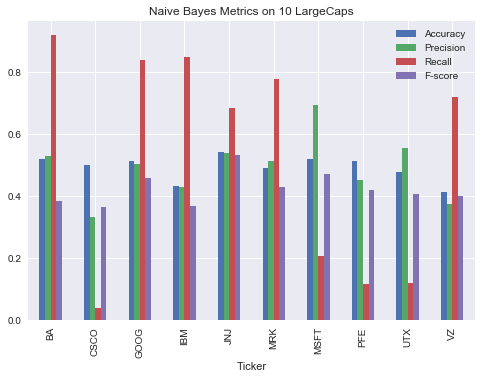

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import cross_validation, datasets 
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns

columns = ['Ticker','Accuracy', 'Precision','Recall','F-score']
nb_results = pd.DataFrame(columns=columns)

for infile in glob.glob( os.path.join(path, '*.csv') ):
    if "sp.csv" not in infile:       
        base=os.path.basename(infile)
        ticker = os.path.splitext(base)[0]
        ticker = ticker.replace('_processed','')
    
        clf_nb = GaussianNB()
        clf_nb.fit(train_feature_dict[ticker], train_label_dict[ticker])
        y_pred = clf_nb.predict(test_feature_dict[ticker])
        y_test = test_label_dict[ticker]
        nb_results.loc[len(nb_results)] = [ticker, accuracy_score(y_test, y_pred), 
                                   precision_score(y_test,y_pred), 
                                    recall_score(y_test,y_pred),
                                       f1_score(y_test, y_pred, average='macro')]

print("** Naive Bayes Results\n",nb_results)
nb_results.plot(x='Ticker', kind='bar', legend=True, title="Naive Bayes Metrics on 10 LargeCaps")

plt.show()
    

#### Logistic Regression

** Logistic Regression Results
   Ticker  Accuracy  Precision    Recall   F-score
0     BA  0.524691   0.535714  0.862069  0.433489
1   CSCO  0.555556   0.523077  0.871795  0.516578
2   GOOG  0.487654   0.472727  0.325000  0.473016
3    IBM  0.469136   0.443548  0.763889  0.444675
4    JNJ  0.549383   0.539130  0.756098  0.527319
5    MRK  0.503106   0.521008  0.729412  0.464939
6   MSFT  0.512346   0.539823  0.693182  0.482344
7    PFE  0.462963   0.463235  0.818182  0.403883
8    UTX  0.554140   0.597222  0.511905  0.554122
9     VZ  0.487654   0.369863  0.421875  0.475155


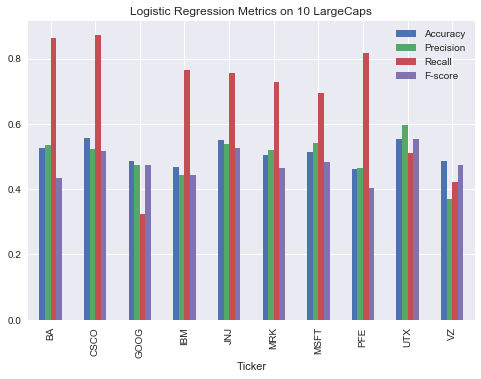

In [36]:
#modified Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn import preprocessing

columns = ['Ticker','Accuracy', 'Precision','Recall','F-score']
lr_results = pd.DataFrame(columns=columns)

for infile in glob.glob( os.path.join(path, '*.csv') ):
    if "sp.csv" not in infile:
        base=os.path.basename(infile)
        ticker = os.path.splitext(base)[0]
        ticker = ticker.replace('_processed','')
        
        clf = LogisticRegression()
        
        clf.fit(train_feature_dict[ticker], train_label_dict[ticker])
  
        y_pred = clf.predict(test_feature_dict[ticker])
        y_test = test_label_dict[ticker]
        
        lr_results.loc[len(lr_results)] = [ticker, accuracy_score(y_test, y_pred), 
                                   precision_score(y_test,y_pred), 
                                    recall_score(y_test,y_pred),
                                       f1_score(y_test, y_pred, average='macro')]

print("** Logistic Regression Results\n",lr_results)
lr_results.plot(x='Ticker', kind='bar', legend=True, title="Logistic Regression Metrics on 10 LargeCaps")

plt.show()
        

#### SVM Classification

** SVM Results
   Ticker  Accuracy  Precision    Recall   F-score
0     BA  0.506173   0.528455  0.747126  0.619048
1   CSCO  0.475309   0.455696  0.461538  0.458599
2   GOOG  0.512346   0.521739  0.150000  0.233010
3    IBM  0.425926   0.384615  0.486111  0.429448
4    JNJ  0.524691   0.523364  0.682927  0.592593
5    MRK  0.559006   0.566038  0.705882  0.628272
6   MSFT  0.537037   0.549618  0.818182  0.657534
7    PFE  0.518519   0.495652  0.740260  0.593750
8    UTX  0.585987   0.611765  0.619048  0.615385
9     VZ  0.475309   0.403670  0.687500  0.508671


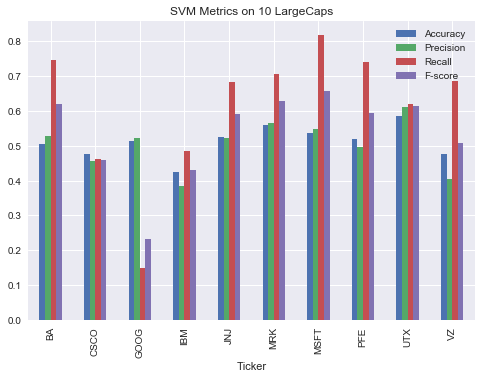

In [33]:
from sklearn import svm
from sklearn.metrics import f1_score


columns = ['Ticker','Accuracy', 'Precision','Recall','F-score']
svm_results = pd.DataFrame(columns=columns)


for infile in glob.glob( os.path.join(path, '*.csv') ):
    if "sp.csv" not in infile:  
        base=os.path.basename(infile)
        ticker = os.path.splitext(base)[0]
        ticker = ticker.replace('_processed','')
        
        clf = svm.SVC(kernel="rbf")
        
        clf.fit(train_feature_dict[ticker], train_label_dict[ticker])
  
        y_pred = clf.predict(test_feature_dict[ticker])
        y_test = test_label_dict[ticker]
        
        svm_results.loc[len(svm_results)] = [ticker, accuracy_score(y_test, y_pred), 
                                   precision_score(y_test,y_pred), 
                                    recall_score(y_test,y_pred),
                                       f1_score(y_test, y_pred)]
    
print("** SVM Results\n",svm_results)
svm_results.plot(x='Ticker', kind='bar', legend=True, title="SVM Metrics on 10 LargeCaps")

plt.show()

### Refinement

#### Logistic Regression with Regularizers

/Users/venuv/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/venuv/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/venuv/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/venuv/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/venuv/anaconda/lib/python3.6/si

** Logistic Regression with L2 regularization/scaling/paramgrid Results
   Ticker  Accuracy  Precision    Recall   F-score
0     BA  0.524691   0.535714  0.862069  0.433489
1   CSCO  0.555556   0.523077  0.871795  0.516578
2   GOOG  0.487654   0.472727  0.325000  0.473016
3    IBM  0.469136   0.443548  0.763889  0.444675
4    JNJ  0.549383   0.539130  0.756098  0.527319
5    MRK  0.503106   0.521008  0.729412  0.464939
6   MSFT  0.512346   0.539823  0.693182  0.482344
7    PFE  0.462963   0.463235  0.818182  0.403883
8    UTX  0.554140   0.597222  0.511905  0.554122
9     VZ  0.487654   0.369863  0.421875  0.475155


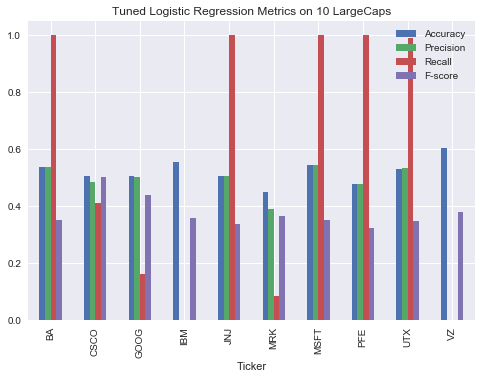

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

columns = ['Ticker','Accuracy', 'Precision','Recall','F-score']
lr_tuned_results = pd.DataFrame(columns=columns)

for infile in glob.glob( os.path.join(path, '*.csv') ):
    if "sp.csv" not in infile:
        base=os.path.basename(infile)
        ticker = os.path.splitext(base)[0]
        ticker = ticker.replace('_processed','')
        
        prm_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
        clf_lr_refined = GridSearchCV(LogisticRegression(penalty='l2'), prm_grid)
        GridSearchCV(cv=None,
           estimator=LogisticRegression(C=1.0, intercept_scaling=1, dual=False, fit_intercept=True,
            penalty='l2', tol=0.0001),
            param_grid=prm_grid)

        scaler = StandardScaler(with_mean=False)
        X = train_feature_dict[ticker]
        X = scaler.fit_transform(X)
        clf_lr_refined.fit(X, train_label_dict[ticker])
        
        y_test = test_label_dict[ticker]
        y_pred = clf_lr_refined.predict(test_feature_dict[ticker])

        lr_tuned_results.loc[len(lr_tuned_results)] = [ticker, accuracy_score(y_test, y_pred), 
                                   precision_score(y_test,y_pred), 
                                    recall_score(y_test,y_pred),
                                       f1_score(y_test, y_pred, average='macro')]

print("** Logistic Regression with L2 regularization/scaling/paramgrid Results\n",lr_results)
lr_tuned_results.plot(x='Ticker', kind='bar', legend=True, title="Tuned Logistic Regression Metrics on 10 LargeCaps")

plt.show()

#### SVM with GridSearch Parameter Tuning (and Scaling)

/Users/venuv/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/venuv/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


** SVM Refined/Scaled Results
   Ticker  Accuracy  Precision    Recall  Best C  Best Gamma   F-score
0     BA  0.543210   0.540373  1.000000    10.0      1.0000  0.701613
1   CSCO  0.481481   0.481481  1.000000     1.0      0.0001  0.650000
2   GOOG  0.506173   0.000000  0.000000     1.0      0.0100  0.000000
3    IBM  0.450617   0.445860  0.972222   100.0      0.0100  0.611354
4    JNJ  0.481481   0.493671  0.951220     1.0      0.1000  0.650000
5    MRK  0.515528   0.522013  0.976471    10.0      0.0010  0.680328
6   MSFT  0.543210   0.543210  1.000000    10.0      0.0100  0.704000
7    PFE  0.475309   0.475309  1.000000   100.0      0.0010  0.644351
8    UTX  0.452229   0.428571  0.071429  1000.0      1.0000  0.122449
9     VZ  0.604938   0.500000  0.046875   100.0      0.0001  0.085714


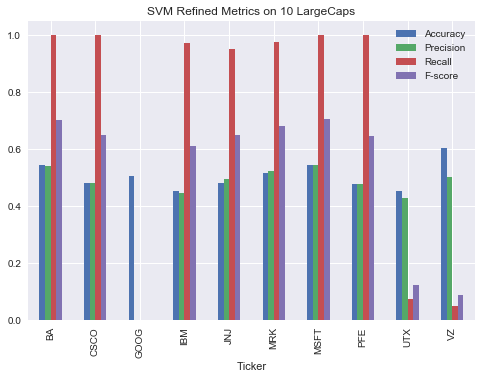

In [52]:
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import preprocessing
from pandas.tools.plotting import table

columns = ['Ticker','Accuracy', 'Precision','Recall','Best C','Best Gamma','F-score']
svm_refined_results = pd.DataFrame(columns=columns)


for infile in glob.glob( os.path.join(path, '*.csv') ):
    if "sp.csv" not in infile:
        base=os.path.basename(infile)
        ticker = os.path.splitext(base)[0]
        ticker = ticker.replace('_processed','')
        
        X_test = test_feature_dict[ticker]
        min_max_scaler = preprocessing.MinMaxScaler()
        X_test = preprocessing.scale(X_test)
        
        Cs = [0.001, 0.01, 0.1, 1, 10,100,1000]
        gammas = [0.0001, 0.001, 0.01, 0.1, 1,10]
        param_grid = {'C': Cs, 'gamma' : gammas}
        clf_svm_refined = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5)
    
        X_train = train_feature_dict[ticker]  
        y_train = train_label_dict[ticker]
        clf_svm_refined.fit(X_train, y_train)
        
        y_test = test_label_dict[ticker]
        y_pred = clf_svm_refined.predict(X_test)
        
        svm_refined_results.loc[len(svm_refined_results)] = [ticker, accuracy_score(y_test, y_pred), 
                                   precision_score(y_test,y_pred), 
                                    recall_score(y_test,y_pred),
                                        clf_svm_refined.best_params_.get('C'),
                                         clf_svm_refined.best_params_.get('gamma'),
                                       f1_score(y_test, y_pred)]
    
print("** SVM Refined/Scaled Results\n",svm_refined_results)
svm_refined_results.to_html('svm_with_hyperparameters_table.html')

#df = df.drop('column_name', 1)
svm_refined_results = svm_refined_results.drop('Best C',1)
svm_refined_results = svm_refined_results.drop('Best Gamma',1)
svm_refined_results.plot(x='Ticker', kind='bar', legend=True, title="SVM Refined Metrics on 10 LargeCaps")

plt.show()

## Results

### Model Evaluation & Validation

The goal of learning the correlation between stock sentiment and 3-day return was to :
- from a 

In [43]:
import subprocess
svm_results.to_html('svm_table.html')
svm_refined_results.to_html('svm_refined_table.html')
lr_results.to_html('lr_table.html')
lr_tuned_results.to_html('lr_tuned_table.html')
nb_results.to_html('nb_table.html')

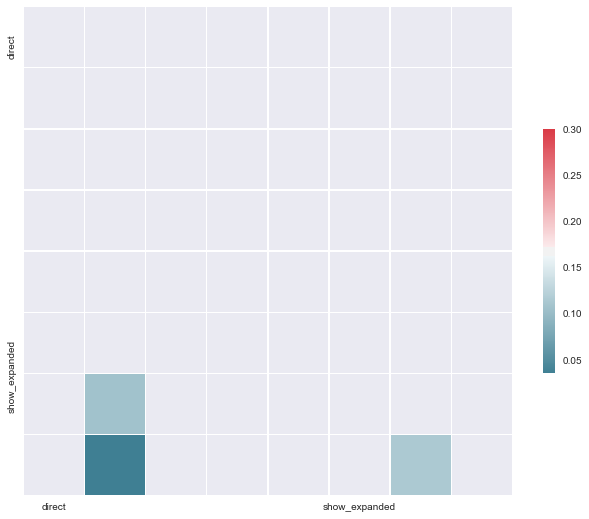

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 10))
merged_clean = imp.fit_transform(merged)
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
#_ = sns.pairplot(merged_clean)
plt.show()

before


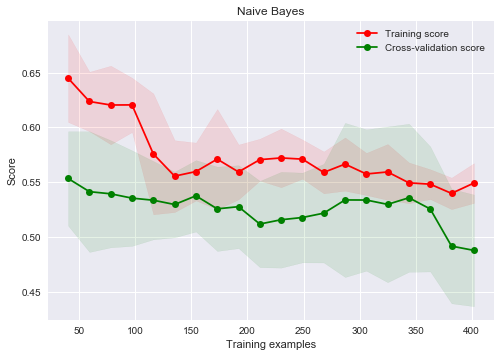

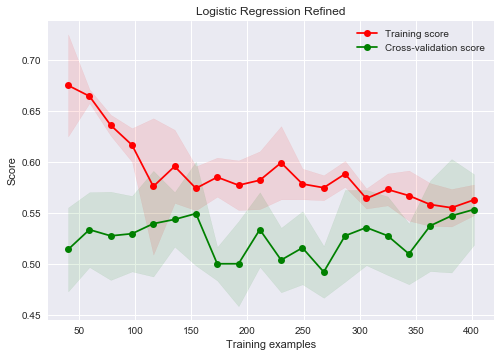

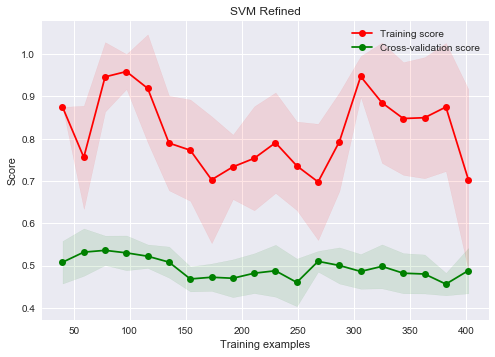

after


In [45]:
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import KFold
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

print("before")
from sklearn.metrics import make_scorer,precision_score
precision_scorer = make_scorer(precision_score)

labels = merged[['positive_return']]
features_df = merged[['message_volume', 'percent_msg_traffic_change', 'msg_rolling_mean', 'bearish_count', 'bullish_count', 'polarity']]
features = features_df.values
targets = labels['positive_return']

features = imp.fit_transform(features)

plot_learning_curve(clf_nb, "Naive Bayes", features, targets, ylim=None, cv=KFold,
                        train_sizes=np.linspace(.1, 1.0, 20))
plt.savefig('lcurves_nb.png')
plot_learning_curve(clf_lr_refined, "Logistic Regression Refined", features, targets, ylim=None, cv=KFold,
                        train_sizes=np.linspace(.1, 1.0, 20))
plt.savefig('lcurves_lr.png')
plot_learning_curve(clf_svm_refined, "SVM Refined", features, targets, ylim=None, cv=KFold,
                        train_sizes=np.linspace(.1, 1.0, 20))
plt.savefig('lcurves_svm.png')

plt.show()

print("after")

In [46]:
svm_refined_results.to_html('filename.html')


### Justification
IQR plots of precision and recall. think of situation where trader wants to make lots of trades.

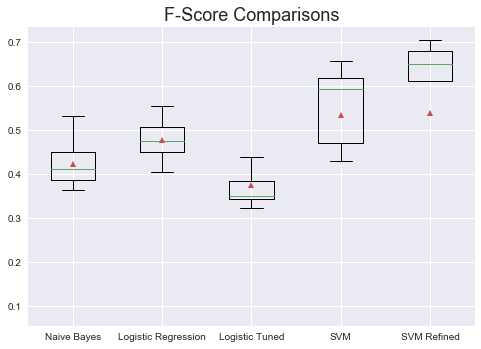

In [50]:
svm_curated_results = svm_refined_results[svm_refined_results['Precision'] > 0]
lr_curated_results = lr_tuned_results[lr_tuned_results['Precision'] > 0]
ml_results=[nb_results['F-score'],lr_results['F-score'],lr_curated_results['F-score'],
            svm_results['F-score'],svm_curated_results['F-score']]


plt.grid(True, axis='y')
plt.title('F-Score Comparisons', fontsize=18)
plt.boxplot(ml_results, showmeans=True,
                notch=False, sym='+', vert=True, whis=1.5)
plt.xticks([1,2,3,4,5], ['Naive Bayes','Logistic Regression', 'Logistic Tuned','SVM','SVM Refined'])
plt.show()

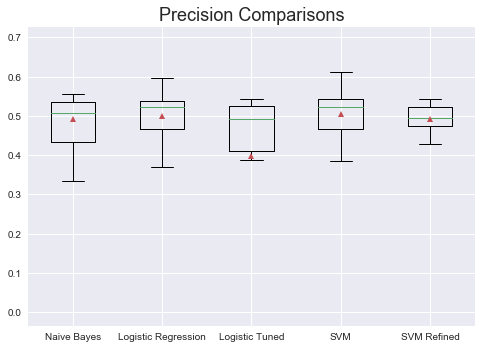

In [51]:
#ml_results=[nb_results['Precision'],lr_results['Precision'],svm_curated_results['Precision']]
pr_results=[nb_results['Precision'],lr_results['Precision'],lr_tuned_results['Precision'],
            svm_results['Precision'],svm_curated_results['Precision']]

plt.grid(True, axis='y')
plt.title('Precision Comparisons', fontsize=18)
plt.boxplot(pr_results, showmeans=True,
                notch=False, sym='+', vert=True, whis=1.5)
#plt.xticks([1,2,3], ['Naive Bayes','Logistic Regression','SVM'])
plt.xticks([1,2,3,4,5], ['Naive Bayes','Logistic Regression', 'Logistic Tuned','SVM','SVM Refined'])
plt.show()